# Face Detection Using Facenet Pytorch VGGFace2 InceptionResnetV1


In this notebook, we will continue using the `facenet-pytorch` library and leverage the power of the `InceptionResnetV1` architecture trained on `VGGFace2` dataset. This pretrained model not only excels at detecting and classifying faces but also offers additional functionalities such as Face Alignment, Facial Expression Recognition, Age Estimation, Gender Classification, and Face Attribute Recognition. While it is possible to load other models, I have chosen this specific model from facenet-pytorch to maintain consistency with the library. However, it is worth noting that other models can perform equally well, and some may prefer using models from Hugging Face.

For training, we will utilize the cropped faces obtained from the face detector notebook. I have manually classified these faces and prepared them for training. To simplify the loading process, we will use the split-folders library, which aids in splitting the dataset into appropriate subsets. This will facilitate the use of DataLoaders and ImageFolder classes, which streamline the data loading pipeline.

Data needs to be in the img/raw_classifcation as describe in the split section with the right classification. This is only trained on our CPT Dataset and in the Face Prediction notebook will have an unknown class that fails to pass the prediction.

In [2]:
#Initialize variables
import os
#change this to your username if running on Jojie without admin permisison
os.environ['XDG_CACHE_HOME'] = '/home/msds2023/rbanquerigo/.cache' 


import splitfolders
import torch
import torch.optim as optim
import torch.nn as nn
import time
import copy
import numpy as np
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
from facenet_pytorch import InceptionResnetV1
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np

In [3]:
#pip install split-folders

This split-folders will be responsible for seggregating the images from the input folder however we need to ensure that under the input folder each of the folders are separated between classes.  We also defined the split as required by the assignment 60% = training, 20% validation, 20% test)

    img/raw_classifcation/bj/{images}....
    img/raw_classifcation/greg/{images}....
    img/raw_classifcation/loraine/{images}....
    img/raw_classifcation/rozz/{images}....
    
Post running the splitfolders we need to remove the .ipynb_checkpoints hidden folder as it will cause an issue with the ImageLoader object.
 
     rm -rf .ipynb_checkpoints

In [4]:
# input_folder = 'img/raw_classification'  
# output_folder= 'img/data'
# splitfolders.ratio(input_folder, output= output_folder, seed=1337, ratio = (0.6, 0.2, 0.2), move=False)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

I have utilized the code from the notebook to calculate the mean and standard deviation of the images in the training set. These values will be used to normalize the validation and test sets. Image is resize to 224x224 as the standard input for the `InceptionResnetV1` VGGFace2 model.

The root folder contains the images in the directory "/train", organized into classes. The images are located under the "img/data/" folder.

To properly handle the dataset, I used the datasets.ImageFolder class. It automatically separates the images into classes based on the folder names. Additionally, the transformations defined in the transforms object are applied to the data using the data_transforms variable.

In [6]:
#load only training set for the mean and std
data_dir = 'img/data/'

data_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(root=data_dir+'/train',
                                  transform=data_transforms)

# compute for the means and stds (for normalization)
imgs = torch.stack([img_t for img_t, _ in train_data], dim=3)
means = imgs.view(3, -1).mean(dim=1).numpy()
stds = imgs.view(3, -1).std(dim=1).numpy()

print(f'Means:           {means}') 
print(f'Std. Deviations: {stds}')

Means:           [0.558187   0.43328658 0.37717137]
Std. Deviations: [0.23535807 0.19407287 0.17577842]


This code is responsible for dividing the dataset into train, validate, and test sets using the ImageFolder class, which loads the data into the DataLoader object used for iterations.

The train transforms object applies a different set of augmentations randomly. All transformations, including those for train, validation, and test, involve resizing the images to 224x224, converting them to tensors, and normalizing them using the means and standard deviations calculated from the training set.

A batch size of 4-6 has been chosen as it seems to work well. In this case, I have set it to six, and shuffle=True ensures that each iteration loads the data set with a different order of data samples, reducing bias and improving generalization.

In this code, I have not used a loop similar to the lecture as it aims to provide clarity while explaining to a few cohortmates.

In [7]:
#transform with data augmentation for training
train_transforms = transforms.Compose([
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                        transforms.Resize((224, 224)),
                        transforms.RandomCrop((160, 160)),
                        transforms.ToTensor(),
                        transforms.Normalize(means, stds)
                   ])


val_test_transforms = transforms.Compose([
                          transforms.Resize(size=(224,224)),
                          transforms.ToTensor(),                              
                          transforms.Normalize(means, stds)
                      ])

train_dataset = datasets.ImageFolder(root=data_dir+'/train',
                                     transform=train_transforms)
val_dataset = datasets.ImageFolder(root=data_dir+'/val',
                                   transform=val_test_transforms)
test_dataset = datasets.ImageFolder(root=data_dir+'/test',
                                    transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=6, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=6, shuffle=True)


Load `vggface2` model weights ensure that classify is to True and set the number of classes to be predicted we can get it from the dataloader object. We also freezed the existings weights for the gradients as this model is already trained to have high accuracy on faces based on the metrics shown on the github page.

In [8]:
model = (InceptionResnetV1(pretrained='vggface2', 
                          classify=True, 
                          num_classes=len(train_dataset.classes)))

for param in model.parameters():
    param.requires_grad = False 


We can see the architecture of VGGFace stacks of CNN layers, Batch Normalization, RELU for its activation layers and MaxPool in 3 branches of the architecture.

In [9]:
#View InceptionResnetV1 VGGFace2 Architecture
print(model)

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

model.logits is the final layer in the architecture of vggface2 in this code below I created a sequantial object to run chain the set of commands. It did not necessary improved the model since I added dropout which turnoff some nodes however I just wanted to showcase that I have clearly understood that we can update the architecture layers.

Loss function is CrossEntropyLoss as this is the best used for multi-class classification.

Optimizer is set to Adam as this is also best for multi-class classifcation though I have not done great length of testing against all other optimizer but this performed very well vs SGD.

In [54]:
model.logits = nn.Sequential(nn.Linear(512, 256),
                                      nn.ReLU(),
                                      nn.Dropout(0.4),
                                      nn.Linear(256, 4, bias=True))

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.logits.parameters(), lr=0.001)

In [55]:
summary(model, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─BasicConv2d: 1-1                       [-1, 32, 111, 111]        --
|    └─Conv2d: 2-1                       [-1, 32, 111, 111]        (864)
|    └─BatchNorm2d: 2-2                  [-1, 32, 111, 111]        (64)
|    └─ReLU: 2-3                         [-1, 32, 111, 111]        --
├─BasicConv2d: 1-2                       [-1, 32, 109, 109]        --
|    └─Conv2d: 2-4                       [-1, 32, 109, 109]        (9,216)
|    └─BatchNorm2d: 2-5                  [-1, 32, 109, 109]        (64)
|    └─ReLU: 2-6                         [-1, 32, 109, 109]        --
├─BasicConv2d: 1-3                       [-1, 64, 109, 109]        --
|    └─Conv2d: 2-7                       [-1, 64, 109, 109]        (18,432)
|    └─BatchNorm2d: 2-8                  [-1, 64, 109, 109]        (128)
|    └─ReLU: 2-9                         [-1, 64, 109, 109]        --
├─MaxPool2d: 1-4                         [-1, 64, 54, 54]       

Layer (type:depth-idx)                   Output Shape              Param #
├─BasicConv2d: 1-1                       [-1, 32, 111, 111]        --
|    └─Conv2d: 2-1                       [-1, 32, 111, 111]        (864)
|    └─BatchNorm2d: 2-2                  [-1, 32, 111, 111]        (64)
|    └─ReLU: 2-3                         [-1, 32, 111, 111]        --
├─BasicConv2d: 1-2                       [-1, 32, 109, 109]        --
|    └─Conv2d: 2-4                       [-1, 32, 109, 109]        (9,216)
|    └─BatchNorm2d: 2-5                  [-1, 32, 109, 109]        (64)
|    └─ReLU: 2-6                         [-1, 32, 109, 109]        --
├─BasicConv2d: 1-3                       [-1, 64, 109, 109]        --
|    └─Conv2d: 2-7                       [-1, 64, 109, 109]        (18,432)
|    └─BatchNorm2d: 2-8                  [-1, 64, 109, 109]        (128)
|    └─ReLU: 2-9                         [-1, 64, 109, 109]        --
├─MaxPool2d: 1-4                         [-1, 64, 54, 54]       

In [56]:
def train_model(model, criterion, optimizer, num_epochs=5):
    """
        Function will train the model and validate after each epoch. The
        best model based on the validation accuracy will be loaded back
        into the model and returned.
        
        model - model object to be trained and validated
        criterion - loss function 
        optimizer - optimizer for calculating the gradients
        num_epochs - int, number of loops for the training
    """
    
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc, best_acc_train = 0.0, 0.0
    
    for epoch in range(num_epochs):
        
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        x = time.time()
        
        #set model to training train
        model.train()
        running_loss, running_corrects = 0.0, 0
        
        #Loop for the training and uses the train_loader for the dataset
        for i, (inputs, labels) in enumerate(train_loader):
            
            #Sets the object into the same device as the model
            inputs, labels = inputs.to(device), labels.to(device)
            
            #Clears the gradients
            optimizer.zero_grad()
            
            #Feed the model the data for the classifcation
            outputs = model(inputs)
            
            #gets the prediction for this batch
            _, preds = torch.max(outputs, 1)
            
            #Calculate the loss
            loss = criterion(outputs, labels)
            
            #Backprop
            loss.backward()
            
            #Update parameter based on the gradients
            optimizer.step()
            
            #Accumulation of loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        #Total loss and accucary for training
        train_loss = running_loss / len(train_dataset)
        train_acc = running_corrects.double() / len(train_dataset)
        
        print(f'Training Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        
        #set model to eval for validation to not update the gradients disable batchnorm and dropouts
        model.eval()
        running_loss, running_corrects = 0.0, 0
        
        #set to no_grad for the gradients
        with torch.no_grad():
            
             #Loop for the caliation and uses the val_loader for the dataset
            for i, (inputs, labels) in enumerate(val_loader):
                
                 #Sets the object into the same device as the model
                inputs, labels = inputs.to(device), labels.to(device)
                
                #Feed the model the data for the classifcation
                outputs = model(inputs)
                
                #gets the prediction for this batch
                _, preds = torch.max(outputs, 1)
                
                #Calculate the loss
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
        
        #Total loss and accucary for validation
        epoch_loss = running_loss / len(val_dataset)
        epoch_acc = running_corrects.double() / len(val_dataset)
        
        print(f'Valiidation Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        #Check if current model has highest accuracy from the previous epochs and save the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_acc_train = train_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        #Since accuracy reaches 100% we can still have a better model but having the higher training accuracy model
        elif epoch_acc == best_acc and train_acc > best_acc_train:
            best_acc = epoch_acc
            best_acc_train = train_acc
            best_model_wts = copy.deepcopy(model.state_dict())
                    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

The train_model function should be called to initiate the training and validation process. Although you initially trained the model for 20 epochs, you have now set it to train for 50 epochs to allow for more iterations. It's generally beneficial to train for more epochs as it provides an opportunity for the model to learn further.

During training, you noticed that the performance of the train set was inferior to that of the validation set. This difference in performance can be attributed to the limited size of your validation set and the presence of similar content between the train and validation data. This similarity in content might contribute to higher accuracy on the validation set. However, this concern becomes less significant when working with a larger dataset containing approximately 30-40 images per class for you, your wife, and daughter. In this case, the training scores are improved.

It's interesting to note that even ChatGPT expressed a similar sentiment when prompted about this issue. Overall, considering the observations made during training, it seems that increasing the dataset size and ensuring diversity in the validation set can help in achieving more accurate and reliable results.

In [57]:
best_model = train_model(model, criterion, optimizer, num_epochs=50)

Epoch 0/49
----------
Training Loss: 1.2624 Acc: 0.5085
Valiidation Loss: 1.1356 Acc: 0.6316
Epoch 1/49
----------
Training Loss: 0.9999 Acc: 0.5932
Valiidation Loss: 0.9485 Acc: 0.6842
Epoch 2/49
----------
Training Loss: 1.0067 Acc: 0.5932
Valiidation Loss: 0.8492 Acc: 0.7895
Epoch 3/49
----------
Training Loss: 0.8605 Acc: 0.6271
Valiidation Loss: 0.7530 Acc: 0.7368
Epoch 4/49
----------
Training Loss: 0.8262 Acc: 0.6271
Valiidation Loss: 0.6186 Acc: 0.7895
Epoch 5/49
----------
Training Loss: 0.7634 Acc: 0.6610
Valiidation Loss: 0.4905 Acc: 0.8947
Epoch 6/49
----------
Training Loss: 0.8064 Acc: 0.6949
Valiidation Loss: 0.4886 Acc: 0.8947
Epoch 7/49
----------
Training Loss: 1.0125 Acc: 0.6102
Valiidation Loss: 0.5204 Acc: 0.8421
Epoch 8/49
----------
Training Loss: 0.7564 Acc: 0.6610
Valiidation Loss: 0.5679 Acc: 0.8947
Epoch 9/49
----------
Training Loss: 0.9587 Acc: 0.6610
Valiidation Loss: 0.5492 Acc: 0.7895
Epoch 10/49
----------
Training Loss: 0.6320 Acc: 0.7119
Valiidation L

PCC Calculation to set baseline for the accuracy that the model needs to beat.

In [58]:
#Concatenate all datasets
concat_dataset = ConcatDataset([train_loader.dataset, val_loader.dataset, test_loader.dataset])
concat_dataloader = DataLoader(concat_dataset, shuffle=False)
class_counts = {}

#Get all labels for each datapoint
for inputs, labels in concat_dataloader:
    class_ = int(labels[0])
    if class_counts.get(class_) is None:
        class_counts[class_] = 1
    else:
        class_counts[class_] += 1

        total = 0
val_ = []
for key, value in class_counts.items():
    val_.append(value)    
    total += value

pcc = ((np.array(val_) / total)**2).sum()
acc_beat = 1.25*pcc
print(f'PCC: {pcc:.4f}')
print(f'Accuracy to Beat: {acc_beat}')

PCC: 0.2514
Accuracy to Beat: 0.31430742084109403


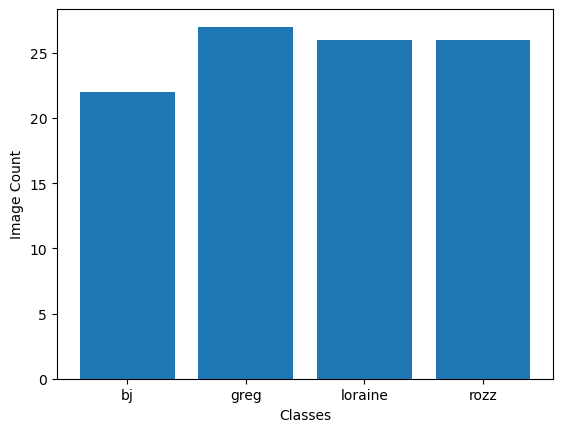

In [59]:
classes = train_dataset.classes
plt.xlabel('Classes')
plt.ylabel('Image Count')
plt.bar(classes, np.array(val_));

In [60]:
def evaluate(model, test_loader):
    
    """
        Test the model with our test set and calculates the accuracy
        and returns it.
        
        model - best model returned fro mthe training iteration
        test_loader - test dataset
    """
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
    acc = (correct / total)
    print(f"Test Accuracy: {acc:.4f}")
    return acc

In [61]:
test_acc = evaluate(best_model, test_loader)
if test_acc > acc_beat:
    print(f'\nModel was able to beat baseline PCC*1.25')
    print(f'Test Accuracy:{test_acc} > PCC:{acc_beat}')
else:
    print()
    print(f'\nModel was not! able to beat baseline PCC*1.25')
    print(f'PCC:{acc_beat} > Test Accuracy:{test_acc}')

Test Accuracy: 0.9130

Model was able to beat baseline PCC*1.25
Test Accuracy:0.9130434782608695 > PCC:0.31430742084109403


In [62]:

#set classes for display based on the order of the loading

def imageshow(img):
    #img = torch.clamp(img, 0, 1) fixes prompt but not clear image
    img = img / 2 + 0.5     # unnormalize
    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2,  0)))
    #plt.imshow((npimg * 255).astype(np.uint8))
    
    plt.show()

def visualize_preds(model):
    # get batch of images from the test DataLoader  
    images, labels = next(iter(test_loader))
    images = images.to(device)
    labels = labels.to(device)

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images.cpu()))
   
   
    # show the real labels  
    print('Real labels: ', ' '.join('%5s' % classes[labels[j]] 
                               for j in range(labels.shape[0])))
    
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    
    # show the predicted labels 
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] 
                              for j in range(labels.shape[0])))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


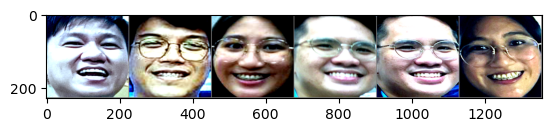

Real labels:   rozz  greg loraine    bj    bj loraine
Predicted:   rozz  rozz loraine    bj    bj loraine


In [63]:
visualize_preds(best_model)

This steps saves the best model along with the mean and std that we will use for the Face Prediction notebook

In [ ]:
#save params
np.savez('mean_std.npz', means=means, stds=stds)
torch.save(best_model.state_dict(), 'best_model.pth')

Code below is to verify that the model is being loaded and re validated against the test set.

In [ ]:
best_model_path = 'best_model.pth'

load_model = (InceptionResnetV1(pretrained='vggface2', 
                          classify=True, 
                          num_classes=4))

#Need to update architecture as this is not saved in the model
load_model.logits = nn.Sequential(nn.Linear(512, 256),
                                      nn.ReLU(),
                                      nn.Dropout(0.4),
                                      nn.Linear(256, 4, bias=True))
load_model.load_state_dict(torch.load(best_model_path, map_location=device.type));
load_model.to(device);

In [ ]:
evaluate(load_model, test_loader)

In [ ]:
visualize_preds(best_model)

### Conclusion

Based on the model scores, we have successfully surpassed the calculated PCC (Pearson correlation coefficient) by maintaining a well-balanced dataset across the four classes during training. Additionally, I have observed the effectiveness of Data Augmentation in enhancing generalization with the photos. It's worth mentioning that having a larger number of samples is beneficial, particularly when dealing with subjects wearing or not wearing spectacles. This is important because there were instances where BJ and Loraine were predicted incorrectly due to the presence of eyeglasses, which became a significant feature for the model to consider.

Regarding model optimization, there are still further experiments to be conducted. However, leveraging pre-trained models proves to be advantageous as it reduces the amount of training required on the dataset. These pre-trained models already possess embedded base features of the faces within their weight architecture, enabling them to learn specific characteristics associated with the classes or faces we aim to predict.